In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import unidecode

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from nltk import tokenize, ngrams
from nltk.tokenize import WordPunctTokenizer
from string import punctuation

In [3]:
resenhas = pd.read_csv("imdb-reviews-pt-br.csv")

classificacao = resenhas["sentiment"].replace(["neg", "pos"], [0, 1])
resenhas["classificacao"] = classificacao

vectorizer = CountVectorizer(lowercase=False,
                            max_features=50)

bag_of_words = vectorizer.fit_transform(resenhas["text_pt"])

treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                               resenhas["classificacao"],
                                                               random_state = 42)

regressao_logistica = LogisticRegression(solver = "lbfgs")

regressao_logistica.fit(treino, classe_treino)

previsao_teste = regressao_logistica.predict_proba(teste)

previsao_teste_bol = previsao_teste[:,1] >= 0.5
previsao_teste_int = previsao_teste_bol.astype(np.int)
acuracia_teste = accuracy_score(classe_teste, previsao_teste_int)

In [4]:
def criar_word_cloud(resenhas, coluna_texto):
    palavras = ' '.join([texto for texto in resenhas[coluna_texto]])
    cloud = WordCloud(width=800, 
        height=500, 
        max_font_size=110,
        collocations=False).generate(palavras)

    plt.figure(figsize=(10, 7))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def gerar_pareto(texto, coluna_texto, quantidade, token):
    palavras = ' '.join([texto for texto in texto[coluna_texto]])
    frequencia = nltk.FreqDist(token.tokenize(palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                  "Frequencia": list(frequencia.values())})
    
    df_frequencia = df_frequencia.nlargest(columns = "Frequencia", n = quantidade)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y= "Frequencia", color = "gray")
    ax.set(ylabel = "Contagem")
    plt.show()

def tratar_resenha(resenhas, coluna_texto, words, token):
    frase_processada = list()
    for opiniao in resenhas[coluna_texto]:
        nova_frase = list()
        palavras_texto = token.tokenize(opiniao)
        for palavra in palavras_texto:
            if palavra not in words:
                nova_frase.append(palavra)
        frase_processada.append(' '.join(nova_frase))
    return(frase_processada)


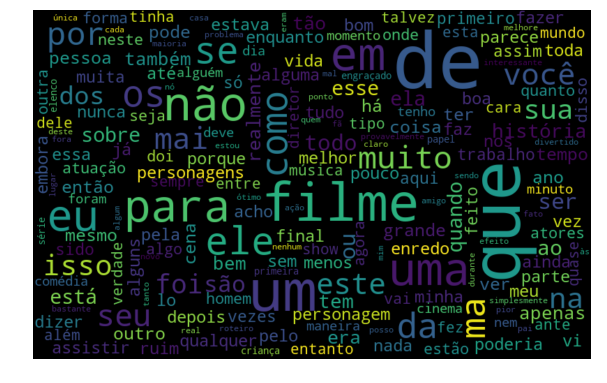

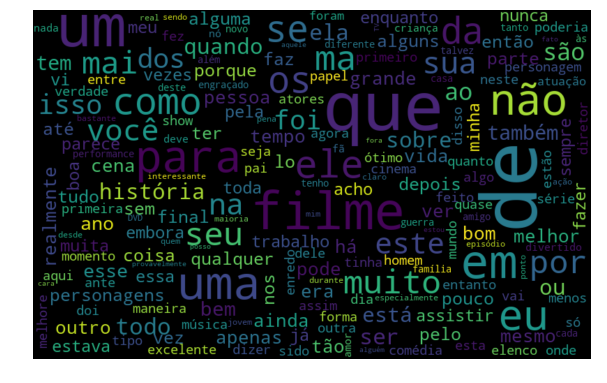

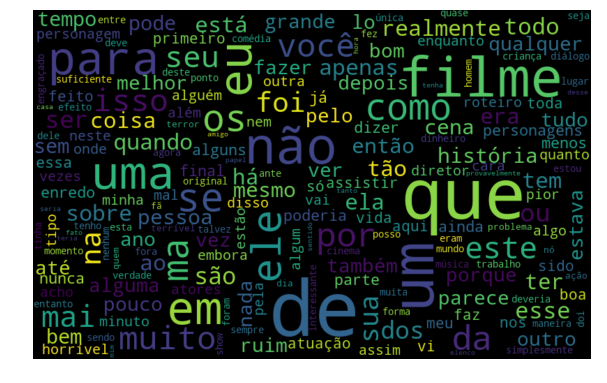

In [5]:
COL_PT = "text_pt"
QUERY_POS = "sentiment == 'pos'"
QUERY_NEG = "sentiment == 'neg'"

criar_word_cloud(resenhas,  COL_PT)
resenhas_positivas = resenhas.query(QUERY_POS)
criar_word_cloud(resenhas_positivas, COL_PT)
resenhas_negativas = resenhas.query(QUERY_NEG)
criar_word_cloud(resenhas_negativas,COL_PT)

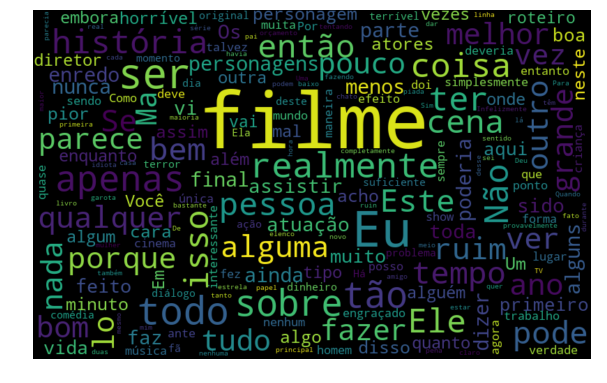

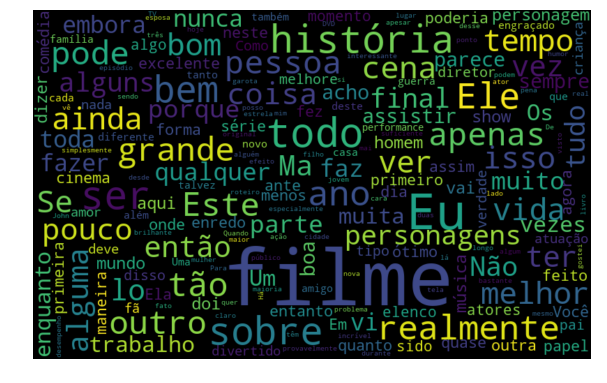

In [8]:
## REMOVENDO STOPWORDS DAS RESENHAS
##nltk.download("stopwords")
COL_SW = "tratamento_1"
token_espaco = tokenize.WhitespaceTokenizer()
stopwords = nltk.corpus.stopwords.words("portuguese")  

resenhas_neg_sw = resenhas.query(QUERY_NEG)
resenhas[COL_SW] = tratar_resenha(resenhas, COL_PT, stopwords, token_espaco)
criar_word_cloud(resenhas_neg_sw, COL_SW)
resenhas_pos_sw = resenhas.query(QUERY_POS)
criar_word_cloud(resenhas_pos_sw, COL_SW)
##print(resenhas[COL_SW])

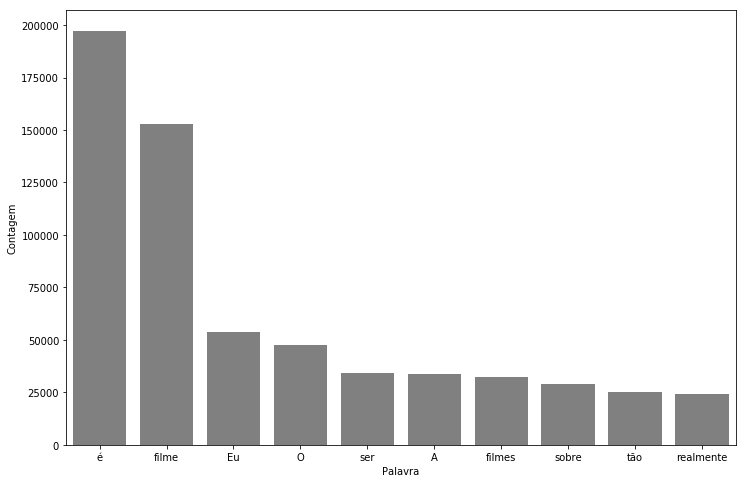

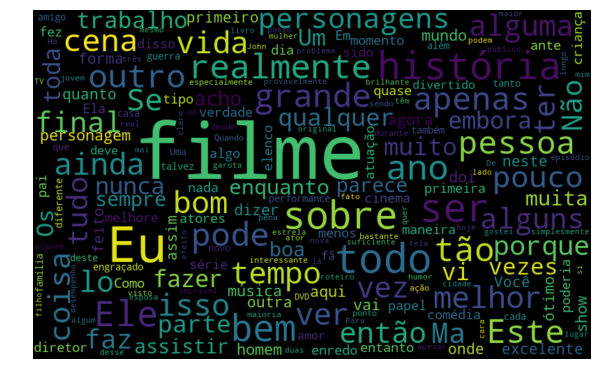

In [12]:
## REMOVENDO PONTUAÇÃO DAS RESENHAS
COL_PONTUACAO = "tratamento_2"
pontuacao = [ponto for ponto in punctuation]
token_pontuacao = tokenize.WordPunctTokenizer()
pontuacao_stopwords = pontuacao + stopwords
resenhas[COL_PONTUACAO] = tratar_resenha(resenhas, COL_SW, pontuacao_stopwords, token_pontuacao)
gerar_pareto(resenhas, "tratamento_2", 10, token_espaco)
criar_word_cloud(resenhas_pos_sw, COL_SW)

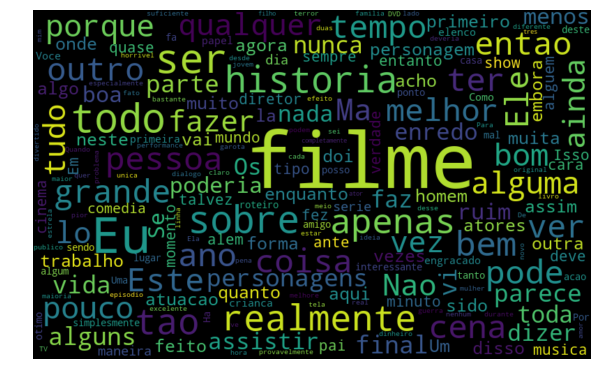

In [16]:
## REMOVENDO ACENTOS
COL_ACENTOS = "tratamento_3"
sem_acentos = [unidecode.unidecode(texto) for texto in resenhas[COL_PONTUACAO]]
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]
resenhas[COL_ACENTOS] = sem_acentos
resenhas[COL_ACENTOS] = tratar_resenha(resenhas, COL_ACENTOS, stopwords_sem_acento, token_pontuacao)
criar_word_cloud(resenhas, COL_ACENTOS)

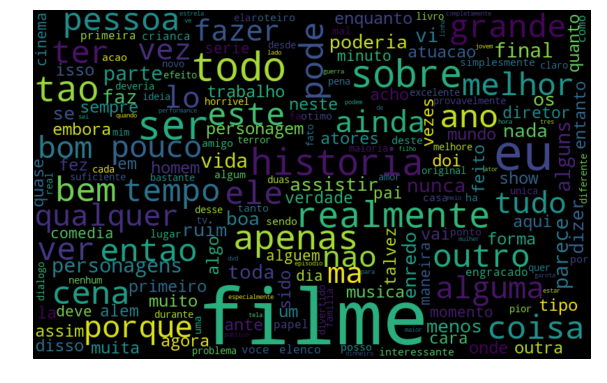

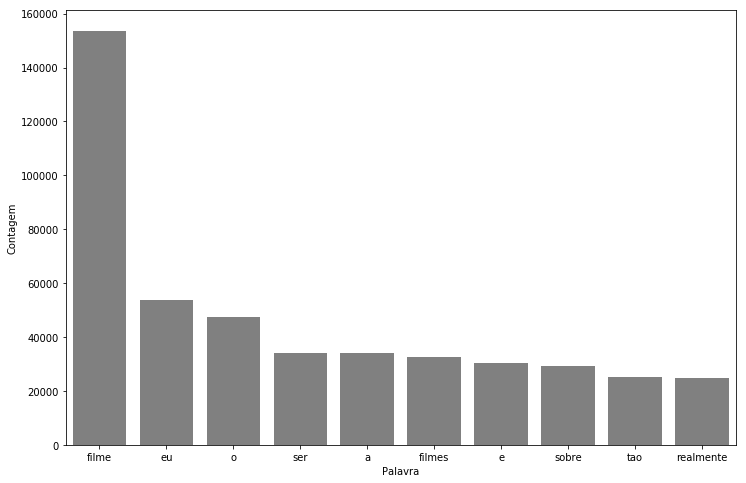

In [17]:
## PASSANDO O TEXT PARA LOWERCASE
COL_LOWER = "tratamento_4"
frase_processada = list()
for opiniao in resenhas[COL_ACENTOS]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        nova_frase.append(palavra)
    frase_processada.append(" ".join(nova_frase))

resenhas[COL_LOWER] = frase_processada
criar_word_cloud(resenhas, COL_LOWER)
gerar_pareto(resenhas, COL_LOWER, 10, token_pontuacao)

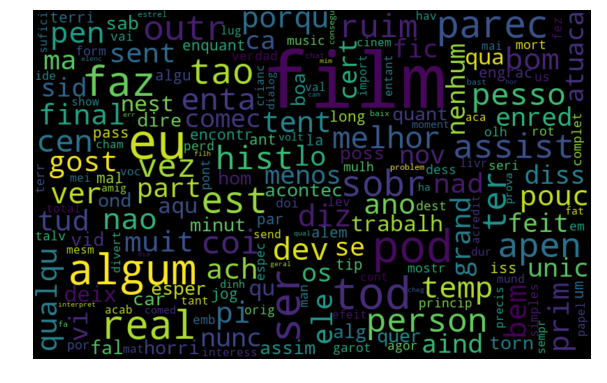

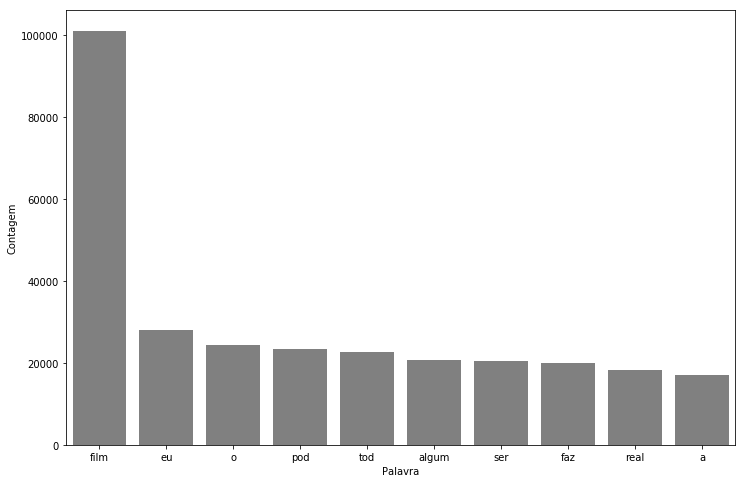

In [20]:
## COLHENDO RADICAIS
##nltk.download('rslp')
stemmer = nltk.RSLPStemmer()
COL_RAIZ = "tratamento_5"
processadas = list()
for opiniao in resenhas[COL_LOWER]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        nova_frase.append(stemmer.stem(palavra))
    processadas.append(' '.join(nova_frase))

resenhas[COL_RAIZ] = processadas

#criar_word_cloud(resenhas.query(QUERY_POS), COL_RAIZ)
criar_word_cloud(resenhas.query(QUERY_NEG), COL_RAIZ)
gerar_pareto(resenhas.query(QUERY_NEG), COL_RAIZ, 10, token_pontuacao)

In [28]:
## TFIDF NGRAMS
##nltk.download("ngrams")
tfidf = TfidfVectorizer(lowercase=False,
                        ngram_range=(1, 2))
vetor_tfidf = tfidf.fit_transform(resenhas[COL_RAIZ])
##ngram = ngrams(token_espaco.tokenize(resenhas[COL_RAIZ]), 2)

treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                            resenhas["classificacao"],
                                                            random_state=42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf = regressao_logistica.score(teste, classe_teste)
acuracia_tfidf

0.887019813991104

In [29]:
pesos = pd.DataFrame(regressao_logistica.coef_[0].T,
                    index = tfidf.get_feature_names())
pesos.nlargest(10, 0)

,0
otim,9.810435
excel,8.909825
perfeit,6.834833
maravilh,6.210040
favorit,5.793282
incri,5.701953
divert,5.441011
brilh,4.806453
hoj,4.467669
ador,4.409181
